<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**Комментарий студента:**
- проект выполнен на Google Colab;  
- ориентировочное время выполнение 20 минут.

## Подготовка
Работа выполнена в Google Colab (TPU).  
Установка библиотеки transformers


In [1]:
#!pip install transformers
!pip install catboost
!pip install pytorch-transformers

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May  9 20:18:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    42W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Импорт необходимых библиотек:

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,make_scorer,accuracy_score
from sklearn.svm import SVC,LinearSVC

from catboost import Pool, CatBoostClassifier



from tqdm import notebook,tqdm, trange
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.dummy import DummyClassifier
import lightgbm
 
nltk.download('wordnet','stopwords','punkt','averaged_perceptron_tagger')
from nltk.corpus import wordnet

import time 
 
import warnings
warnings.filterwarnings('ignore')


from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline

from pytorch_transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification

from IPython.display import clear_output
import matplotlib.pyplot as plt
import io

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences



## Импорт данных


In [4]:
try:
    comments = pd.read_csv('/datasets/toxic_comments.csv')
except:
    comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [5]:
comments.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Преимущественно не токсичные комментарии соотношение 89,8% к 10,2% 

In [6]:
comments.toxic.value_counts()/comments.shape[0]*100 #.plot(kind='bar')

0    89.832112
1    10.167888
Name: toxic, dtype: float64

In [7]:
def df_info(df):
    '''
  функция дает общее представление о датасете
  
  '''  
    #print(80*"+")
    df.info()
    print(80*"+")
    print(f'количество пропусков по столбцам:')
    for i,j in enumerate(df.columns):
      print(j,'=',df.iloc[:,i].isnull().sum())
    print('Описание количественных переменных:')
    print(df.describe(percentiles=[.25,.5]))
    print(80*"+")
    print(f'количество дубликатов в таблице = {df.duplicated().sum()}')

In [8]:
df_info(comments)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
количество пропусков по столбцам:
text = 0
toxic = 0
Описание количественных переменных:
               toxic
count  159571.000000
mean        0.101679
std         0.302226
min         0.000000
25%         0.000000
50%         0.000000
max         1.000000
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
количество дубликатов в таблице = 0


In [9]:
comments['text'] = comments['text'].values.astype('U')

приведем все буквенные данные к нижнему регистру

In [10]:
comments['text'] = comments['text'].str.lower()

оставим только буквы в нижнем и верхнем регистре + цифры

In [11]:
comments_new = []
pattern = r'[^a-zA-Z0-9]' #r'[^a-zA-z]' [^a-zA-Z0-9]
for sentence in comments.text:
  cleared_text = re.sub(pattern, " ", sentence)
  comments_new.append(" ". join(cleared_text.split()))

In [12]:
comments["clear_text"]=comments_new
comments.head()

,text,toxic,clear_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...


## Обучение

Для дальнейшего использования 159571 очень большой датасет, поэтому сделаем sample.


переменную **corpus** будем использовать для TF-IDF,  
**corpus_b** для модели BERT

In [13]:
sample_size = 20000
corpus = comments.sample(n=sample_size,random_state=0).reset_index(drop=True)
print('соотношение классов в датасете corpus\n', corpus.toxic.value_counts()/corpus.shape[0]*100)

соотношение классов в датасете corpus
 0    89.73
1    10.27
Name: toxic, dtype: float64


Соотношение классов приблизтельно как в исходном датасете.  
Можно считать, что baseline по accuracy для данного датасета около  90.

Будем применять Wordnet Lemmatizer + Pos_tag

In [14]:
corpus.head()

,text,toxic,clear_text
0,"""\ni haven't paraphrased you at all, gary. yo...",0,i haven t paraphrased you at all gary you comp...
1,i blocked revers! i blocked revers! i blocked ...,1,i blocked revers i blocked revers i blocked re...
2,i'm sorry. i'd like to unreservedly retract my...,1,i m sorry i d like to unreservedly retract my ...
3,i don't know if this is exactly like the press...,0,i don t know if this is exactly like the press...
4,"thank you all, we'll all improve the wikipedia...",0,thank you all we ll all improve the wikipedia ...


In [15]:
# инициализация Wordnet Lemmatizer
L = WordNetLemmatizer()

In [16]:
def lemmatizered(corpus):
  ''' функция выполняет токенизациию и лемматизацию массива текстов'''
  corpus_new = []
  for sentence in corpus:
    word_list = nltk.word_tokenize(sentence)
    corpus_new.append(' '.join([L.lemmatize(w) for w in word_list]))
  return corpus_new

In [17]:
nltk.download('stopwords')
stopwords.words('english')[:5]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we']

In [18]:
def get_wordnet_pos(word):
    """функция возвращает словарь, где возвращается значение часть речи (pos_tag)"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
 
    return tag_dict.get(tag, wordnet.NOUN)

In [19]:
def get_word_text(corpus):
  ''' функция выполняет токенизациию и лемматизацию массива текстов c учетом pos_tag и удаление стоп-слов'''
  corpus_new = []
  for sentence in corpus:
    corpus_new.append(' '.join([L.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence) if not w in stopwords.words('english')]))
  return corpus_new

Выполним лемматизацию корпуса c учетом pos_tag

In [20]:
 %%time
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
 
corpus['lemma_text_no_sw'] = get_word_text(corpus['clear_text'])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
CPU times: user 3min 51s, sys: 17.5 s, total: 4min 9s
Wall time: 4min 8s


In [21]:
corpus.head()

,text,toxic,clear_text,lemma_text_no_sw
0,"""\ni haven't paraphrased you at all, gary. yo...",0,i haven t paraphrased you at all gary you comp...,paraphrase gary complain prefer recent source ...
1,i blocked revers! i blocked revers! i blocked ...,1,i blocked revers i blocked revers i blocked re...,block revers block revers block revers block r...
2,i'm sorry. i'd like to unreservedly retract my...,1,i m sorry i d like to unreservedly retract my ...,sorry like unreservedly retract previous state...
3,i don't know if this is exactly like the press...,0,i don t know if this is exactly like the press...,know exactly like press release use source htt...
4,"thank you all, we'll all improve the wikipedia...",0,thank you all we ll all improve the wikipedia ...,thank improve wikipedia 2007 dear thanks warm ...


## Train/Test

разделим наши данные на train_corpus ,test_corpus.  
test_corpus в дальнейшем будем использовать для тестирования модели.

In [22]:
train = []
# потребуется для Word2vec
for sentences in corpus['lemma_text_no_sw']:
  train.append(sentences.split())

corpus['split'] = train

In [23]:
train_corpus,test_corpus = train_test_split(corpus, test_size=0.2, random_state =0,stratify = corpus['toxic'])


In [24]:
train_corpus.head()

,text,toxic,clear_text,lemma_text_no_sw,split
4025,dealings with stargirl \n\ni have head somethi...,0,dealings with stargirl i have head something t...,dealing stargirl head something one part infin...,"[dealing, stargirl, head, something, one, part..."
5722,"""\n\n look \n\nlook dude, that was just in the...",0,look look dude that was just in the sandbox wh...,look look dude sandbox limitation unconstructi...,"[look, look, dude, sandbox, limitation, uncons..."
4733,as you have been refreshingly blunt let me be ...,1,as you have been refreshingly blunt let me be ...,refreshingly blunt let keep dick hammersoft aw...,"[refreshingly, blunt, let, keep, dick, hammers..."
17847,ascii art barnstar \n\nfor your ascii images a...,0,ascii art barnstar for your ascii images at wp...,ascii art barnstar ascii image wp rd hereby aw...,"[ascii, art, barnstar, ascii, image, wp, rd, h..."
8163,there were several links in this section to di...,0,there were several links in this section to di...,several link section disambiguation page chang...,"[several, link, section, disambiguation, page,..."


In [25]:
print('соотношение классов в train_corpus n', train_corpus.toxic.value_counts()/train_corpus.shape[0]*100)
print('соотношение классов в test_corpus n', test_corpus.toxic.value_counts()/test_corpus.shape[0]*100)

соотношение классов в train_corpus n 0    89.73125
1    10.26875
Name: toxic, dtype: float64
соотношение классов в test_corpus n 0    89.725
1    10.275
Name: toxic, dtype: float64


# Bag of Words

In [26]:
def treshold(array,tresh_list,y_test):
  ''' функция настраивает порог классификации для метода predict_proba'''
  best_result = 0
  #best_predict = []
  for i in tresh_list:
    tmp_list = np.empty([len(array),2])
    for j,k in enumerate(array[:,1]):
      if k<i:
        tmp_list[j,1] = 0
      else:
        tmp_list[j,1] = 1
    result = f1_score(y_test,tmp_list[:,1])
    #print(result,i)   
    if result>best_result:
      best_result=result
      best_tresh = i
      #best_predict = tmp_list
  return best_result,best_tresh

In [27]:
def result_write(model_name,f1,f1_p,t,time_fit):
  ''' 
  функция добавляет значения метрики f1 по умолчания, f1 c учетом измененного порога,
  порог, время настройки модели
  '''
  result_df.loc[model_name,'F1_predict'] = f1
  result_df.loc[model_name,'F1_predict_proba'] = f1_p
  result_df.loc[model_name,'Treshold'] = t
  result_df.loc[model_name,'Time_fit'] = time_fit
  return result_df

In [28]:
# создаем n-грамму n_gramm, для которой n=2
count_vect = CountVectorizer(ngram_range=(2, 4))
n_gramm_train = count_vect.fit(train_corpus['lemma_text_no_sw'])
n_gramm_train = count_vect.transform(train_corpus['lemma_text_no_sw'])
n_gramm_test = count_vect.transform(test_corpus['lemma_text_no_sw'])
print("Размер train:", n_gramm_train.shape,"Размер test:",n_gramm_test.shape)
#count_vect.get_feature_names()

Размер train: (16000, 1295064) Размер test: (4000, 1295064)


In [29]:
f1 = make_scorer(f1_score)

In [30]:
parameters = {'C': np.linspace(0.01, 500, 5),'class_weight':['balanced']}
grid_search = GridSearchCV(estimator=LogisticRegression(),param_grid = parameters, n_jobs=-1,cv=5) #scoring='f1'

grid_search.fit(n_gramm_train, train_corpus['toxic'])
grid_search.best_params_ 

{'C': 250.005, 'class_weight': 'balanced'}

In [31]:
start = time.time()
lr_clf_bow = LogisticRegression(**grid_search.best_params_,random_state = 0)
lr_clf_bow.fit(n_gramm_train, train_corpus['toxic'])
end = time.time()
time_fit = end - start

lr_clf_bow_predict = lr_clf_bow.predict(n_gramm_test)
lr_clf_bow_predict_proba = lr_clf_bow.predict_proba(n_gramm_test)


In [32]:
f1_lr_clf_bow = f1_score(lr_clf_bow_predict,test_corpus['toxic'])
f1_lr_clf_bow_result,f1_lr_clf_bow_tresh = treshold(lr_clf_bow_predict_proba,np.linspace(0.1,0.9,100),test_corpus['toxic'])
                         



In [33]:
result_df = pd.DataFrame(columns=['F1_predict','F1_predict_proba','Treshold','Time_fit'])
result_df

,F1_predict,F1_predict_proba,Treshold,Time_fit


In [34]:
result_write('Bag of words + LorReg',f1_lr_clf_bow,f1_lr_clf_bow_result,f1_lr_clf_bow_tresh,time_fit)

,F1_predict,F1_predict_proba,Treshold,Time_fit
Bag of words + LorReg,0.291913,0.447761,0.293939,32.5933


# Catboost

In [36]:
text_features = ['lemma_text_no_sw'] #0.76
#text_features = ['text']# 0.72
#text_features = ['clear_text'] #0.73
target = 'toxic'

Теперь мы будем использовать модель текстовые признаки в модели catboost.  
В работе CatBoost'a есть 3 этапа:

- Токенизация
- Создание словаря
- Подсчет признаков
Конфигурировать весь процесс можно через text_processing, передав вложенный словарь.

Для простоты:
токенизация будет по пробелу (нужно задать токенизатор)
создадим 2-6 gram'ы (нужно создать соответствующие словари)
выполним подсчет признаков (укажим какие признаки подсчитываем на словаре)
Пример словаря:

{
            "dictionary_id" : "Trigram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "3"
}
Создали словарь 3-грам (gram_order - этот параметр определяет какой вид n-gram'a создается), на символах (token_level_type, поддерживается еще уровень Word), нижняя граница частоты 3-граммы равна 1 (occurrence_lower_bound), так же нужно указать размер словаря (это скажется на предварительных подсчетах)

Затем нужно посчитать признаки. CatBoost позволяет считать 3 вида признаков:

- Bow (Bag-of-Words)
- NaiveBayes
- BM25





In [37]:
cat = CatBoostClassifier( 
    text_features=text_features,
    verbose=50,
    loss_function='Logloss',
    eval_metric='F1',
    task_type="GPU",
    iterations=1000,
    learning_rate=0.2,
    random_seed = 0,
    auto_class_weights = 'Balanced',
    #class_weights =dict({0:1, 1:9}),
    text_processing = {
        "tokenizers" : [{
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "delimiter" : " "
        }],

        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "token_level_type": "Letter",
            "max_dictionary_size" : "150000",
            "occurrence_lower_bound" : "1",
            "gram_order" : "2"
        },{
            "dictionary_id" : "Trigram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "3"
        },{
            "dictionary_id" : "Fourgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "4"
        },{
            "dictionary_id" : "Fivegram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "5"
        },{
            "dictionary_id" : "Sixgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "6"
        #},{
        #    "dictionary_id" : "Sevengram",
        #    "max_dictionary_size" : "150000",
        #    "token_level_type": "Letter",
        #    "occurrence_lower_bound" : "1",
        #   "gram_order" : "7"
        }
        ],

        "feature_processing" : {
            "default" : [
                    {
                    "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],#,"Sevengram"],
                    "feature_calcers" : ["BoW"],
                    "tokenizers_names" : ["Space"]
                },
                    {
                "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],#,"Sevengram"],
                "feature_calcers" : ["NaiveBayes"],
                "tokenizers_names" : ["Space"]
            },{
                "dictionaries_names" : [ "BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],#,"Sevengram"],
                "feature_calcers" : ["BM25"],
                "tokenizers_names" : ["Space"]
            },
            ],
        }
    }
)

In [38]:
start = time.time()
cat.fit(
    train_corpus[text_features], train_corpus[target],
    eval_set=(test_corpus[text_features], test_corpus[target]),
    plot=True
)
end = time.time()
time_fit = end - start

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8102791	test: 0.8507009	best: 0.8507009 (0)	total: 51.1ms	remaining: 51.1s
50:	learn: 0.8910457	test: 0.8800753	best: 0.8820203 (33)	total: 2.3s	remaining: 42.8s
100:	learn: 0.9138206	test: 0.8739654	best: 0.8820203 (33)	total: 4.46s	remaining: 39.7s
150:	learn: 0.9303693	test: 0.8728719	best: 0.8820203 (33)	total: 6.71s	remaining: 37.7s
200:	learn: 0.9459043	test: 0.8696689	best: 0.8820203 (33)	total: 8.97s	remaining: 35.7s
250:	learn: 0.9555873	test: 0.8704401	best: 0.8820203 (33)	total: 11.2s	remaining: 33.5s
300:	learn: 0.9650231	test: 0.8672047	best: 0.8820203 (33)	total: 13.5s	remaining: 31.4s
350:	learn: 0.9693020	test: 0.8635484	best: 0.8820203 (33)	total: 15.8s	remaining: 29.3s
400:	learn: 0.9722666	test: 0.8581026	best: 0.8820203 (33)	total: 18.1s	remaining: 27s
450:	learn: 0.9752923	test: 0.8550078	best: 0.8820203 (33)	total: 20.4s	remaining: 24.8s
500:	learn: 0.9791539	test: 0.8581990	best: 0.8820203 (33)	total: 22.7s	remaining: 22.6s
550:	learn: 0.9806444	test:

In [39]:
cat_f1 = f1_score(cat.predict(test_corpus[text_features]),test_corpus[target])
cat_pred_proba = cat.predict_proba(test_corpus[text_features])
cat_result,cat_tresh = treshold(cat_pred_proba,np.linspace(0.1,0.9,100),test_corpus[target])
#print('лучшее значение f1 и порог равны',cat_result,cat_tresh)

In [40]:
result_write('Catboost',cat_f1,cat_result,cat_tresh,time_fit)

,F1_predict,F1_predict_proba,Treshold,Time_fit
Bag of words + LorReg,0.291913,0.447761,0.293939,32.5933
Catboost,0.681018,0.74476,0.770707,70.5295


#TF-IDF

выполним векторизацию слов методом TfidfVectorize.  
Метод fit настривает модель, transform выполняет вектризацию.

In [41]:
count_tf_idf = TfidfVectorizer(stop_words = 'english') #ngram_range=(2, 2)
tf_idf = count_tf_idf.fit(train_corpus['lemma_text_no_sw'])
tf_idf_train = tf_idf.transform(train_corpus['lemma_text_no_sw'])
test_tf_idf = tf_idf.transform(test_corpus['lemma_text_no_sw'])

In [42]:
print("Размер матрицы train:", tf_idf_train.shape,"Размер матрицы test:", test_tf_idf.shape)


Размер матрицы train: (16000, 39852) Размер матрицы test: (4000, 39852)


Обозначим что есть признаки и таргеты для трейн и тест.

In [43]:
X_train = tf_idf_train
X_test = test_tf_idf
y_train = train_corpus['toxic'].values
y_test = test_corpus['toxic'].values

In [44]:
print(X_train.shape,X_test.shape)

(16000, 39852) (4000, 39852)


По заданию нужно добиться значения F-меры более 0.75  

$$F1 = \frac{2*precision*recall}{precion + recall}$$



### Логистическая классификация для TF-IDF

In [45]:
parameters = {'C': np.linspace(0.01, 5000, 50),'class_weight':['balanced']}
grid_search = GridSearchCV(estimator=LogisticRegression(),param_grid = parameters, n_jobs=-1,cv=5) #scoring='f1'
start = time.time()
grid_search.fit(X_train, y_train)
grid_search.best_params_ 


{'C': 102.05061224489796, 'class_weight': 'balanced'}

In [46]:
lr_clf_TF_IDF = LogisticRegression(**grid_search.best_params_,random_state = 0)

lr_clf_TF_IDF.fit(X_train, y_train)
end = time.time()
time_fit = end - start

In [47]:
f1_lr_clf = f1_score(lr_clf_TF_IDF.predict(X_test),y_test)
f1_lr_clf

0.7259073842302879

подберем порог классификации

In [48]:
f1_lr_clf_predict_proba = lr_clf_TF_IDF.predict_proba(X_test)
lr_clf_TF_IDF_result,lr_clf_TF_IDF_tresh = treshold(f1_lr_clf_predict_proba,np.linspace(0.1,0.9,50),y_test)
result_write('TF-IDF+Log reg',f1_lr_clf,lr_clf_TF_IDF_result,lr_clf_TF_IDF_tresh,time_fit)

,F1_predict,F1_predict_proba,Treshold,Time_fit
Bag of words + LorReg,0.291913,0.447761,0.293939,32.5933
Catboost,0.681018,0.74476,0.770707,70.5295
TF-IDF+Log reg,0.725907,0.740157,0.638776,67.3024


## DummyClassifier

In [49]:
start = time.time()
clf = DummyClassifier(random_state=0)
clf.fit(X_train, y_train)
end = time.time()
time_fit = end - start

Dummy_predict = clf.predict(X_test)
Dummy_f1 = f1_score(Dummy_predict,y_test)
Dummy_predict_proba = clf.predict_proba(X_test)
dummy_TF_IDF_result,dummy_TF_IDF_tresh = treshold(Dummy_predict_proba,np.linspace(0.001,0.9,50),y_test)
result_write('TF-IDF+DummyClassifier',Dummy_f1,dummy_TF_IDF_result,dummy_TF_IDF_tresh,time_fit)

,F1_predict,F1_predict_proba,Treshold,Time_fit
Bag of words + LorReg,0.291913,0.447761,0.293939,32.5933
Catboost,0.681018,0.74476,0.770707,70.5295
TF-IDF+Log reg,0.725907,0.740157,0.638776,67.3024
TF-IDF+DummyClassifier,0.112544,0.112544,0.001,0.00112438


# Word2Vec

In [50]:
class GensimWord2VecVectorizer(BaseEstimator, TransformerMixin):
    """
    Word vectors are averaged across to create the document-level vectors/features.
    gensim's own gensim.sklearn_api.W2VTransformer doesn't support out of vocabulary words,
    hence we roll out our own.
    All the parameters are gensim.models.Word2Vec's parameters.
    https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
    """

    def __init__(self, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None,
                 sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5,
                 ns_exponent=0.75, cbow_mean=1, hashfxn=hash, iter=5, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False,
                 callbacks=(), max_final_vocab=None):
        self.size = size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.ns_exponent = ns_exponent
        self.cbow_mean = cbow_mean
        self.hashfxn = hashfxn
        self.iter = iter
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words
        self.compute_loss = compute_loss
        self.callbacks = callbacks
        self.max_final_vocab = max_final_vocab

    def fit(self, X, y=None):
        self.model_ = Word2Vec(
            sentences=X, corpus_file=None,
            size=self.size, alpha=self.alpha, window=self.window, min_count=self.min_count,
            max_vocab_size=self.max_vocab_size, sample=self.sample, seed=self.seed,
            workers=self.workers, min_alpha=self.min_alpha, sg=self.sg, hs=self.hs,
            negative=self.negative, ns_exponent=self.ns_exponent, cbow_mean=self.cbow_mean,
            hashfxn=self.hashfxn, iter=self.iter, null_word=self.null_word,
            trim_rule=self.trim_rule, sorted_vocab=self.sorted_vocab, batch_words=self.batch_words,
            compute_loss=self.compute_loss, callbacks=self.callbacks,
            max_final_vocab=self.max_final_vocab)
        return self

    def transform(self, X):
        X_embeddings = np.array([self._get_embedding(words) for words in X])
        return X_embeddings

    def _get_embedding(self, words):
        valid_words = [word for word in words if word in self.model_.wv.vocab]
        if valid_words:
            embedding = np.zeros((len(valid_words), self.size), dtype=np.float32)
            for idx, word in enumerate(valid_words):
                embedding[idx] = self.model_.wv[word]

            return np.mean(embedding, axis=0)
        else:
            return np.zeros(self.size)

In [51]:
gensim_word2vec_tr = GensimWord2VecVectorizer(size=50, min_count=2,window=5, sg=1, alpha=0.025, iter=10)#min_count=3,window=5

cat_w2v = CatBoostClassifier(
    verbose=50,
    loss_function='Logloss',
    eval_metric='F1',
    #task_type="GPU",
    iterations=2000,
    learning_rate=0.1,
    auto_class_weights = 'Balanced'
    )

CAT_w2v = Pipeline([
    ('w2v', gensim_word2vec_tr), 
    ('cat_w2v', cat_w2v)
])
CAT_w2v


Pipeline(memory=None,
         steps=[('w2v',
                 GensimWord2VecVectorizer(alpha=0.025, batch_words=10000,
                                          callbacks=(), cbow_mean=1,
                                          compute_loss=False,
                                          hashfxn=<built-in function hash>,
                                          hs=0, iter=10, max_final_vocab=None,
                                          max_vocab_size=None, min_alpha=0.0001,
                                          min_count=2, negative=5,
                                          ns_exponent=0.75, null_word=0,
                                          sample=0.001, seed=1, sg=1, size=50,
                                          sorted_vocab=1, trim_rule=None,
                                          window=5, workers=3)),
                ('cat_w2v',
                 <catboost.core.CatBoostClassifier object at 0x7fb311c65ad0>)],
         verbose=False)

In [52]:
start = time.time()
CAT_w2v.fit(train_corpus['split'], train_corpus['toxic'],
           )
elapse = time.time() - start
print('elapsed: ', elapse)
CAT_w2v

0:	learn: 0.8119154	total: 16.1ms	remaining: 32.3s
50:	learn: 0.9004463	total: 608ms	remaining: 23.2s
100:	learn: 0.9329559	total: 1.2s	remaining: 22.6s
150:	learn: 0.9618198	total: 1.78s	remaining: 21.9s
200:	learn: 0.9767304	total: 2.37s	remaining: 21.2s
250:	learn: 0.9855164	total: 2.97s	remaining: 20.7s
300:	learn: 0.9896970	total: 3.55s	remaining: 20.1s
350:	learn: 0.9934315	total: 4.14s	remaining: 19.5s
400:	learn: 0.9951541	total: 4.73s	remaining: 18.9s
450:	learn: 0.9965018	total: 5.31s	remaining: 18.2s
500:	learn: 0.9976797	total: 5.89s	remaining: 17.6s
550:	learn: 0.9986866	total: 6.47s	remaining: 17s
600:	learn: 0.9992431	total: 7.07s	remaining: 16.5s
650:	learn: 0.9995215	total: 7.65s	remaining: 15.9s
700:	learn: 0.9995911	total: 8.22s	remaining: 15.2s
750:	learn: 0.9995911	total: 8.81s	remaining: 14.6s
800:	learn: 0.9996259	total: 9.38s	remaining: 14s
850:	learn: 0.9996259	total: 10s	remaining: 13.5s
900:	learn: 0.9996608	total: 10.6s	remaining: 12.9s
950:	learn: 0.9996608

Pipeline(memory=None,
         steps=[('w2v',
                 GensimWord2VecVectorizer(alpha=0.025, batch_words=10000,
                                          callbacks=(), cbow_mean=1,
                                          compute_loss=False,
                                          hashfxn=<built-in function hash>,
                                          hs=0, iter=10, max_final_vocab=None,
                                          max_vocab_size=None, min_alpha=0.0001,
                                          min_count=2, negative=5,
                                          ns_exponent=0.75, null_word=0,
                                          sample=0.001, seed=1, sg=1, size=50,
                                          sorted_vocab=1, trim_rule=None,
                                          window=5, workers=3)),
                ('cat_w2v',
                 <catboost.core.CatBoostClassifier object at 0x7fb311c65ad0>)],
         verbose=False)

In [53]:
y_test_pred = CAT_w2v.predict(test_corpus['split'])
f1_w2v = f1_score(test_corpus['toxic'] ,y_test_pred)
y_test_pred_proba = CAT_w2v.predict_proba(test_corpus['split'])
result_w2v,tresh_w2v = treshold(y_test_pred_proba,np.linspace(0.1,0.9,100),test_corpus['toxic'])

result_write('Word2Vec + Catboost',f1_w2v,result_w2v,tresh_w2v,time_fit)

,F1_predict,F1_predict_proba,Treshold,Time_fit
Bag of words + LorReg,0.291913,0.447761,0.293939,32.5933
Catboost,0.681018,0.74476,0.770707,70.5295
TF-IDF+Log reg,0.725907,0.740157,0.638776,67.3024
TF-IDF+DummyClassifier,0.112544,0.112544,0.001,0.00112438
Word2Vec + Catboost,0.700379,0.715026,0.584848,0.00112438


#BERT

На основе *Based on [BERT Fine-Tuning Sentence Classification notebook on Colab](https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=6J-FYdx6nFE_), refined by [Anastasia Ianina](https://www.linkedin.com/in/anastasia-ianina/)*, доработанной Анастасией Яниной



Если есть GPU, будем использовать ее для обучения. Тем не менее, этот ноутбук d разделе BERT можно выполнить и с помощью только CPU. Правда, это будет значительно дольше.

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla P100-PCIE-16GB GPUs


Обратите внимание на специальные токены [CLS] и [SEP], которые мы добавляем в началои конец предложения.

In [55]:
sentences = corpus['clear_text'].values # text

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

labels = corpus['toxic'].values

In [56]:
assert len(sentences) == len(labels)

In [57]:
print(sentences[100])

[CLS] i m in favour of your proposal too javits now i understand better where you re coming from [SEP]


In [58]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.2)

In [59]:
print(len(train_gt), len(test_gt))

16000 4000


## Inputs
Теперь импортируем токенизатор для BERT'а, который превратит наши тексты в набор токенов, соответствующих тем, что встречаются в словаре предобученной модели.

In [60]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

['[CLS]', 'i', 'would', 'suggest', 'removing', 'it', 'but', 'that', 's', 'up', 'to', 'the', 'editors', 'i', 'was', 'just', 'pointing', 'out', 'that', 'it', 'is', 'a', 'false', 'claim', 'if', 'not', 'removed', 'you', 'might', 'just', 'change', 'the', 'word', '##ing', 'to', 'something', 'like', 'in', 'computer', 'simulations', 'many', 'genes', 'have', 'been', 'shown', 'to', 'potentially', 'occur', 'via', 'frames', '##hi', '##ft', 'mutations', 'but', 'that', 'doesn', 't', 'have', 'quite', 'the', 'same', 'ring', 'to', 'it', '76', '179', '130', '102', '[SEP]']


BERT'у нужно предоставить специальный формат входных данных.

   - **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре,
   - **labels**: вектор из нулей и единиц. В нашем случае единицы обозначают негативную эмоциональную окраску, нули - положительную.
   - **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.,
   - **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.
   
Паддинг нужен для того, чтобы BERT мог работать с предложениями разной длины. Выбираем максимально возможную длину предложения (в нашем случае пусть это будет 150).

Теперь более длинные предложения будем обрезать до 150 токенов, а для более коротких использовать паддинг. Возьмем готовую функцию pad_sequences из библиотеки keras.

In [61]:
MAX_LEN = 160
BATCH_SIZE = 32
input_ids = [tokenizer.convert_tokens_to_ids(x[:150]) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=MAX_LEN, # 150
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Делим данные на train и val:

In [62]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

Преобразуем данные в pytorch тензоры:

In [63]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [64]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [65]:
train_labels

tensor([0, 0, 0,  ..., 0, 0, 0])

Воспользуемся классом DataLoader. Это поможет нам использовать эффективнее память во время тренировки модели, так как нам не нужно будет загружать в память весь датасет. Данные по батчам будем разбивать произвольно с помощью RandomSampler. Также обратите внимание на размер батча: если во время тренировки возникнет Memory Error, размер батча необходимо уменьшить.

In [66]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=BATCH_SIZE # 40
)

In [67]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=BATCH_SIZE # 40
)

### Обучение модели

Теперь когда данные подготовлены, надо написать пайплайн обучения модели.

Для начала мы хотим изменить предобученный BERT так, чтобы он выдавал метки для классификации текстов, а затем файнтюнить его на наших данных. Мы возьмем готовую модификацию BERTа для классификации из pytorch-transformers. Она интуитивно понятно называется BertForSequenceClassification. Это обычный BERT с добавленным линейным слоем для классификации.

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

Аналогичные модели есть и для других задач. Все они построены на основе одной и той же архитектуры и различаются только верхними слоями.

In [68]:
#from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

Теперь подробнее рассмотрим процесс файн-тюнинга. Как мы помним, первый токен в каждом предложении - это [CLS]. В отличие от скрытого состояния, относящего к обычному слову (не метке [CLS]), скрытое состояние относящееся к этой метке должно содержать в себе аггрегированное представление всего предложения, которое дальше будет использоваться для классификации. Таким образом, когда мы скормили предложение в процессе обучения сети, выходом будет вектор со скрытым состоянием, относящийся к метке [CLS]. Дополнительный полносвязный слой, который мы добавили, имеет размер [hidden_state, количество_классов], в нашем случае количество классов равно двум. То есть нав выходе мы получим два числа, представляющих классы "положительная эмоциональная окраска" и "отрицательная эмоциональная окраска".

Процесс дообучения достаточно дешев. По факту мы тренируем наш верхний слой и немного меняем веса во всех остальных слоях в процессе, чтобы подстроиться под нашу задачу.

Иногда некоторые слои специально "замораживают" или применяют разные стратегии работы с learning rate, в общем, делают все, чтобы сохранить "хорошие" веса в нижних слоях и ускорить дообучение. В целом, замораживание слоев BERTа обычно не сильно сказывается на итоговом качестве, однако надо помнить о тех случаях, когда данные, использованные для предобучения и дообучения очень разные (разные домены или стиль: академическая и разговорная лексика). В таких случаях лучше тренировать все слои сети, не замораживая ничего.

Загружаем BERT. bert-base-uncased - это версия "base" (в оригинальной статье рассказывается про две модели: "base" vs "large"), где есть только буквы в нижнем регистре ("uncased").

In [69]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2) # 
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Теперь обсудим гиперпараметры для обучения нашей модели. Авторы статьи советуют выбирать learning rate 5e-5, 3e-5, 2e-5, а количество эпох не делать слишком большим, 2-4 вполне достаточно. Мы пойдем еще дальше и попробуем дообучить нашу модель всего за одну эпоху.

In [70]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)

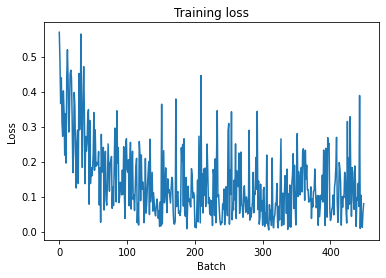

Loss на обучающей выборке: 0.14206
Процент правильных предсказаний на валидационной выборке: 96.62%


In [71]:
# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()

for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.array(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [72]:
print("f1_score: {0:.2f}%".format(
    f1_score(valid_labels, valid_preds)
))

f1_score: 0.82%


## Оценка качества на отложенной выборке

Качество на валидационной выборке оказалось очень хорошим. Не переобучилась ли наша модель?

Делаем точно такую же предобработку для тестовых данных, как и в начале ноутбука делали для обучающих данных:

In [73]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x[:MAX_LEN]) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=MAX_LEN,
    dtype="long",
    truncating="post",
    padding="post"
)

Создаем attention маски и приводим данные в необходимый формат:

In [74]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=BATCH_SIZE
)

In [75]:
start = time.time()
time_fit = end - start
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.array(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

end = time.time()
time_fit = end - start    

In [76]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 96.30%


In [77]:
f1_score(test_labels, test_preds)

0.8163771712158809

In [78]:
result_write('BERT',f1_score(test_labels, test_preds),f1_score(test_labels, test_preds),0,time_fit)

,F1_predict,F1_predict_proba,Treshold,Time_fit
Bag of words + LorReg,0.291913,0.447761,0.293939,32.5933
Catboost,0.681018,0.74476,0.770707,70.5295
TF-IDF+Log reg,0.725907,0.740157,0.638776,67.3024
TF-IDF+DummyClassifier,0.112544,0.112544,0.001,0.00112438
Word2Vec + Catboost,0.700379,0.715026,0.584848,0.00112438
BERT,0.816377,0.816377,0,21.9059


# Вывод:
1. выполнено моделирование при помощи следюущих методов:
  - Bag of words;
  - Catboost;
  - TF-IDF + Log reg;
  - Word1vec;
  - BERT;
2. В процессе обучения использовалась выборка в 20000 сэмплов;
3. Лучший результат показала модель BERT.
